In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.pipeline import Pipeline

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/priyanshi9692/CMPE257-Detect-Covid19-Misinformation/main/corona_fake.csv')

In [3]:
data.head(10)


,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake
5,CORONA UNMASKED: Chinese Intelligence Officer ...,NaN,NaN,NaN
6,NaN,Urgent: Health Bulletin to the Public. Ministr...,Ministry of Health,Fake
7,NaN,"Pls tell ur families, relatives and friendsMOH...",NWLLAB,Fake
8,NaN,SERIOUS EXCELLENT ADVICE by Japanese doctors t...,Japanese doctors treating COVID-19 cases,Fake
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,TRUE


In [4]:
#check the lable values
data['label'].value_counts()

TRUE    584
Fake    345
fake    230
Name: label, dtype: int64

In [5]:
#replace lable value "fake" and "Fake" with "Not Genuine"
# and "True" with "Genuine"

data["label"]= data["label"].str.replace("fake", "Not Genuine", case = False)

In [6]:
data["label"]= data["label"].str.replace("Fake", "Not Genuine", case = False)

In [7]:
data['label'].value_counts()

TRUE           584
Not Genuine    575
Name: label, dtype: int64

In [8]:
data["label"]= data["label"].str.replace("True", "Genuine", case = False)

In [9]:
data['label'].value_counts()

Genuine        584
Not Genuine    575
Name: label, dtype: int64

In [10]:
#check if column lable has null value
label_column=data['label'].isnull()
label_column


0       False
1       False
2       False
3       False
4       False
        ...  
1159    False
1160    False
1161    False
1162    False
1163    False
Name: label, Length: 1164, dtype: bool

In [11]:
#find the row which has lable column null
for i in range (1164):
    if(label_column[i]==True):
        print(i)

5
15
43
131
242


In [12]:
#replace lable column null values
data.loc[5]['label'] = 'Not Genuine'
data.loc[15]['label'] = 'Genuine'
data.loc[43]['label'] = 'Not Genuine'
data.loc[131]['label'] = 'Genuine'
data.loc[242]['label'] = 'Not Genuine'

In [13]:
#check null values of all the columns 
data.isnull().sum()

title     82
text      10
source    20
label      0
dtype: int64

In [14]:
#replace null values with blank 
data=data.fillna(' ')

In [15]:
print(data.isnull().sum())

title     0
text      0
source    0
label     0
dtype: int64


In [16]:
# Combine text and title column to 

data['total']=data['text']+' '+data['title']

In [17]:
#Removing punctuations and converting data to lowercase¶
data['total'] = data['total'].str.replace('[^\w\s]','')
data['total'] = data['total'].str.lower()

In [18]:
data['total'][0]

'you just need to add water and the drugs and vaccines are ready to be administered there are two parts to the kit one holds pellets containing the chemical machinery that synthesises the end product and the other holds pellets containing instructions that telll the drug which compound to create mix two parts together in a chosen combination add water and the treatment is ready due to the recent outbreak for the coronavirus covid19 the world health organization is giving away vaccine kits just pay 495 for shipping'

In [19]:
data['total'][100]

'every virology lab in the world that has run a genomic analysis of the coronavirus now knows that the coronavirus was engineered by human scientists the proof is in the virus itself the tools for genetic insertion are still present as remnants in the genetic code since these unique gene sequences dont occur by random chance theyre proof that this virus was engineered by scientists in a lab but the who and cdc are covering up this inconvenient fact in order to protect communist china and its biological weapons program since no government wants the public to know the full truth about how frequently governmentrun labs experience outbreaks decades ago for example the us army ran an ebola bioweapons lab in the united states where a monkey infected one of the scientists there the strain turned out to be infectious only in monkeys not humans so the world dodged a bullet but the us army nuked the entire facility with chemical bombs killing all the monkeys and wiping out any last remnant of th

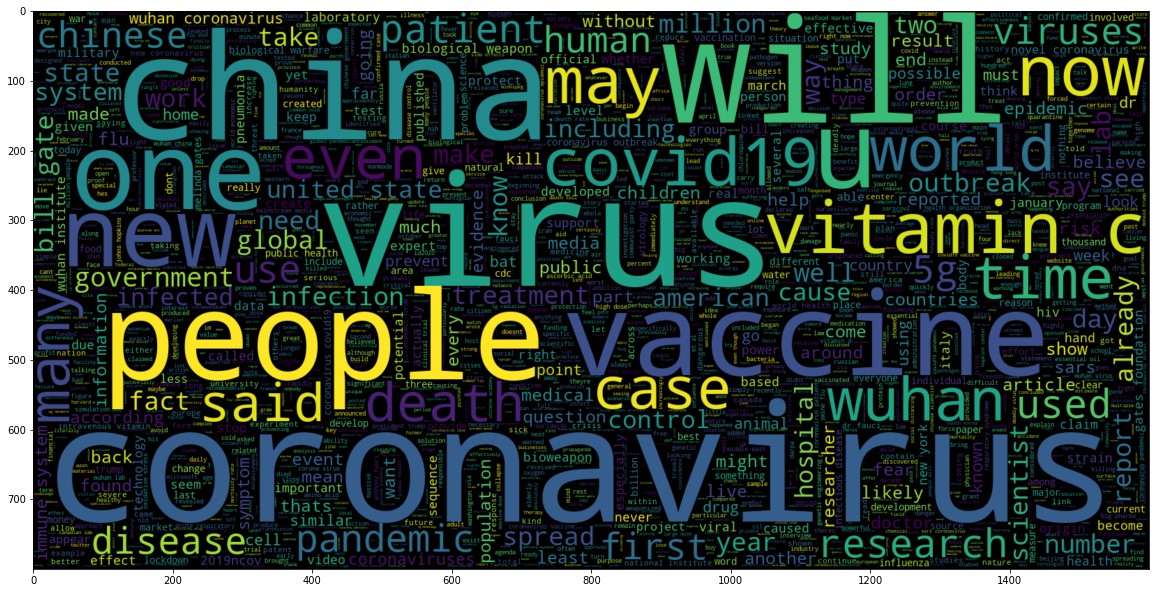

In [20]:
#word cloud vizualization 

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == "Not Genuine"].total))
plt.imshow(wc, interpolation = 'bilinear')

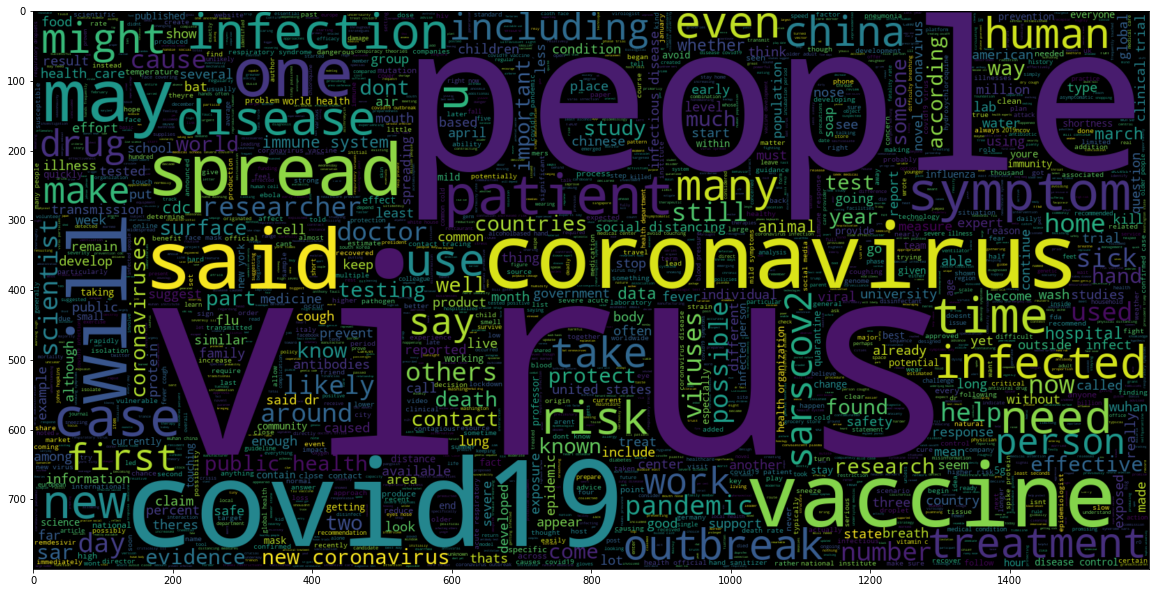

In [21]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == "Genuine"].total))
plt.imshow(wc, interpolation = 'bilinear')

In [22]:
#split the data in train and test 

y=data.label
y

0       Not Genuine
1       Not Genuine
2       Not Genuine
3       Not Genuine
4       Not Genuine
           ...     
1159        Genuine
1160        Genuine
1161        Genuine
1162        Genuine
1163        Genuine
Name: label, Length: 1164, dtype: object

In [23]:
data.drop("label", axis=1,inplace=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data['total'], y, test_size=0.2,random_state=102)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(931,) (931,)
(233,) (233,)


In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.80)  
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [26]:

xgb_model = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
xgb_model.fit(tfidf_train, y_train)
pred3 = xgb_model.predict(tfidf_test)

print('Accuracy of XGBoost on test set:',accuracy_score(y_test, pred3))


Accuracy of XGBoost on test set: 0.871244635193133


In [27]:
results3=confusion_matrix(y_test, pred3)
print(results3)

[[ 97  10]
 [ 20 106]]


In [28]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('clf',xgb_model)])

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=2, subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [30]:

result=pipeline.predict(["One of the challenges being faced worldwide is the rate of infection of health professionals while treating COVID-19 patients.  2016 statistics show the following picture of Rwanda’s health sector: 1/50,505 ground ambulance / population Ratio; 1/10,055 Doctor/population ratio; 1/1,094 Nurse/population ratio; 1/10,500 Laboratory technicians /population ratio. Although Rwanda is on track to meeting most of the required quota, the country cannot afford the set back that a pandemic like COVID-19 among health professionals would cause. To minimize contact time with confirmed cases and therefore reducing the risk of contamination of health professionals in COVID-19 treatment centres, robots were deployed. At Gatenga and Kanyinya treatment centres in Kigali City, visits by medical staff to patients went from 3-4 to 2 per day since May 2020. The 5 human-size robots are programmed to perform temperature screening, take readings of vitals, deliver video messages and detect people not wearing masks then instruct them to wear masks properly. On Tuesday, May 19 at the Kanyinya COVID-19 Treatment Centre, the 5 robots were launched by the Ministry of Health. Named in Kinyarwanda, Akazuba, Ikirezi, Mwiza, Ngabo, and Urumuri are made by Zora Bots, a Belgian company specialised in robotics. They were acquired through a partnership between the UNDP Rwanda Accelerator Lab (AccLab) and the Ministry of ICT and Innovation.  Each robot costs about $30,000. Urumuri is currently deployed at the Kigali International Airport with the capacity to screen 50 to 150 people per minute and report abnormalities to officers on duty. As Rwanda is reopening Kigali International Airport for commercial international flights from 1st of August, Urumuri will allow to speed up mass screenings of fever for passengers as they land. Smart anti-epidemic robots have been used in Asia to help flatten the COVID-19 curve. The pandemic has proven to be a crosscutting challenge affecting Rwanda in all sectors (Health, Economy, Education, Agriculture, …). It therefore requires different sometimes innovative solutions with available resources like robots."])
print(result)

['Genuine']
